In [23]:
import ROOT
import uproot
import math
import time
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import pandas as pd
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.nn import DynamicEdgeConv, global_max_pool,global_mean_pool,knn_graph,MessagePassing
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_scatter import scatter_max, scatter_mean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
random_state = 42
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

In [2]:
# 打开 ROOT 文件，载入 events tree
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    Z_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,Z_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        Z_layers_all = np.vstack((Z_layers_all, np.vstack(Z_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, Z_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    Z_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, Z_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        Z_layers_all = np.vstack((Z_layers_all, Z_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, Z_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    num_events = len(energy)
    E_layers = []
    N_layers = []
    Z_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        posZ = pos_z[i_event].to_numpy()
        Z_layers_event = np.bincount(layers, weights=posZ*energies, minlength=ECAL_layers)
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        Z_layers.append(Z_layers_event/E_layers_event.clip(min=1e-6))
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,Z_layers,E_truth_flat
#Read Data
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
#E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_test, N_layers_test, Z_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, Z_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.1GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_la

length after zero suppression: 1249703 1249703 1249703 1249703 1249703 1249703
length after event selection: 1249703
length after zero suppression: 59990 59990 59990 59990 59990 59990
length after event selection: 59990
length of E_truth_test: 59990


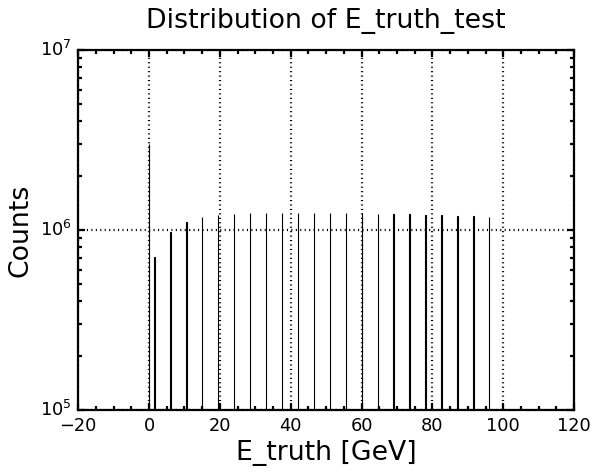

length after event selection: 59990 59990 59990 59990 59990 59990


In [3]:
#zero suppression
def zero_suppression(E_layers, N_layers, Z_layers, E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    Z_sum = np.array([np.sum(z) for z in Z_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]
    Z_layers_filtered = [Z_layers[i] for i in range(len(Z_layers)) if mask[i]]
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(Z_layers_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, Z_layers_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,Z_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, Z_layers, E_truth = zero_suppression(E_layers, N_layers, Z_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    Z_layers = np.array([start_from_shower_layer(ev) for ev in Z_layers])
    print("length after event selection:", len(E_layers))
    return E_layers, N_layers, E_sum, N_sum, Z_layers, E_truth

#E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, Z_layers_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, Z_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, Z_layers_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, Z_layers_test, E_truth_test)
#Draw E_truth
print("length of E_truth_test:", len(E_truth_test))
plt.figure(figsize=fig_size)
plt.hist(Z_layers_uniform.flatten(), bins=1000, range=(0, 100), edgecolor="black")
#plt.hist(E_truth_test, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()
print("length after event selection:", len(E_layers_test), len(N_layers_test), len(E_sum_test), len(N_sum_test), len(Z_layers_test), len(E_truth_test))

In [4]:
E_layers_uniform_ratio = E_layers_uniform / (E_sum_uniform[:, np.newaxis])
N_layers_uniform_ratio = N_layers_uniform / (N_sum_uniform[:, np.newaxis])
E_layers_test_ratio    = E_layers_test / (E_sum_test[:, np.newaxis])
N_layers_test_ratio    = N_layers_test / (N_sum_test[:, np.newaxis])
#performance not good
# E_layers_uniform_exp = np.exp(E_layers_uniform_ratio)
# N_layers_uniform_exp = np.exp(N_layers_uniform_ratio)
# E_layers_test_exp    = np.exp(E_layers_test_ratio)
# N_layers_test_exp    = np.exp(N_layers_test_ratio)

E_N_layers_uniform =  E_layers_uniform/(N_layers_uniform+1e-6)
E_N_layers_test    =  E_layers_test/(N_layers_test+1e-6)
#EN_layers_uniform = E_N_layers_uniform * N_layers_uniform
#EN_layers_test    = E_N_layers_test * N_layers_test

LayerNum_uniform = np.array([np.sum(e>0) for e in E_layers_uniform])
LayerNum_test    = np.array([np.sum(e>0) for e in E_layers_test])
Average_E_layer_uniform = E_sum_uniform / (LayerNum_uniform + 1e-6) 
Average_E_layer_test    = E_sum_test / (LayerNum_test + 1e-6)
Average_N_layer_uniform = N_sum_uniform / (LayerNum_uniform + 1e-6)
Average_N_layer_test    = N_sum_test / (LayerNum_test + 1e-6)

In [5]:
def ScaleFeatures(Features_train, Features_test):
    scaler = StandardScaler().fit(Features_train)
    Features_train_scaled = scaler.transform(Features_train)
    Features_test_scaled  = scaler.transform(Features_test)
    return Features_train_scaled, Features_test_scaled

E_layers_uniform_scaled, E_layers_test_scaled = ScaleFeatures(E_layers_uniform, E_layers_test)
N_layers_uniform_scaled, N_layers_test_scaled = ScaleFeatures(N_layers_uniform, N_layers_test)
Z_layers_uniform_scaled, Z_layers_test_scaled = ScaleFeatures(Z_layers_uniform, Z_layers_test)

extra_features_train = np.hstack([
    E_layers_uniform,
    N_layers_uniform,
    E_layers_uniform_ratio,
    E_sum_uniform[:, np.newaxis],
    N_layers_uniform_ratio,
    N_sum_uniform[:, np.newaxis],
    E_N_layers_uniform,
    #LayerNum_uniform,
    #Average_E_layer_uniform,
    #Average_N_layer_uniform
])

extra_features_test = np.hstack([
    E_layers_test,
    N_layers_test,
    E_layers_test_ratio,
    E_sum_test[:, np.newaxis],
    N_layers_test_ratio,
    N_sum_test[:, np.newaxis],
    E_N_layers_test,
    #LayerNum_test,
    #Average_E_layer_test,
    #Average_N_layer_test
])
extra_features_train, extra_features_test = ScaleFeatures(extra_features_train, extra_features_test)

In [ ]:
def make_event_graph_list(conv_features, pos_features, y_true, extra_features=None, k=3):
    print("shape:", conv_features.shape, pos_features.shape, y_true.shape)
    n_events, n_nodes = conv_features.shape[:2]
    data_list = []
    conv_features = torch.tensor(conv_features, dtype=torch.float32)
    pos_features  = torch.tensor(pos_features, dtype=torch.float32)
    y_true        = torch.tensor(y_true, dtype=torch.float32)
    if extra_features is not None:
        extra_features = torch.tensor(extra_features, dtype=torch.float32)

    for i in range(n_events):
        x_conv = conv_features[i]  # (n_nodes, conv_dim)
        pos    = pos_features[i]   # (n_nodes,) or (n_nodes, pos_dim)
        x = torch.cat([x_conv, pos], dim=-1)  # (n_nodes, conv_dim+pos_dim)
        conv_dim_slice = (0, x_conv.shape[1])
        pos_dim_slice  = (conv_dim_slice[1], conv_dim_slice[1] + pos.shape[1])
        edge_index = knn_graph(pos, k=k, loop=False)
        label = y_true[i]
        extra = extra_features[i].unsqueeze(0) if extra_features is not None else None

        data = Data(
            x=x,
            edge_index=edge_index,
            y=label,
            conv_dim=torch.tensor(conv_dim_slice),  
            pos_dim=torch.tensor(pos_dim_slice),     
            extra=extra
        )
        data_list.append(data)
    return data_list

def get_batch_size(device):
    if device.type == "cuda":
        total_mem = torch.cuda.get_device_properties(device).total_memory / (1024**3)  # GB
        if total_mem < 8:
            return 256
        elif total_mem < 16:
            return 1024
        else:
            return 2048
    else:
        return 128
conv_features_train = np.stack([E_layers_uniform_scaled, N_layers_uniform_scaled], axis=-1)
pos_features_train = Z_layers_uniform_scaled[..., np.newaxis]
conv_features_test = np.stack([E_layers_test_scaled, N_layers_test_scaled], axis=-1)
pos_features_test = Z_layers_test_scaled[..., np.newaxis]
print("shape:", conv_features_train.shape, pos_features_train.shape, extra_features_train.shape)
y_train_true = E_truth_uniform
y_test_true = E_truth_test
KNN_K=3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = get_batch_size(device)
batch_size = 4096 # for llrui02
print("Using device:", device, "with batch size:", batch_size)
data_list_train = make_event_graph_list(
    conv_features=conv_features_train,
    pos_features=pos_features_train,
    y_true=y_train_true,
    extra_features=None,
    k=KNN_K,
)

data_list_test  = make_event_graph_list(
    conv_features=conv_features_test,
    pos_features=pos_features_test,
    y_true=y_test_true,
    extra_features=None,
    k=KNN_K,
)

val_split = 0.2
data_list_train, data_list_val = train_test_split(data_list_train, test_size=val_split, random_state=random_state)


shape: (1249703, 30, 2) (1249703, 30, 1) (1249703, 152)
Using device: cuda with batch size: 4096
shape: (1249703, 30, 2) (1249703, 30, 1) (1249703,)


In [78]:
class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        denom = torch.clamp(y_true + self.eps, min=1e-6)
        ratio = y_pred / denom
        ratio = torch.clamp(ratio, min=-0.99)  # 保证 log1p 有效
        log = torch.log1p(ratio)
        square = torch.square(ratio)
        abs_log = torch.abs(log)
        abs_rel = torch.abs(rel)
        #Basic
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        #loss = torch.where(square < 0.01, 0.5 * rel**3, self.delta * (abs_rel - 0.5*self.delta))
        return torch.mean(loss)
class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = x
        #out = self.activation(out)
        out = self.linear(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out
    
#General MLP with residual blocks, no need for input dim
class MLPRegressor(nn.Module):
    def __init__(self, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.inferred_input_dim = None
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        layers.append(nn.Sequential(
            nn.LazyLinear(hidden_dims[0]),
            #nn.BatchNorm1d(hidden_dims[0]),
            activation,
            nn.Dropout(dropout)
        ))
        prev_dim = hidden_dims[0]
        for h in hidden_dims[1:]:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h

        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)  # 输出事件预测

    def forward(self, x):
        if self.inferred_input_dim is None:
            self.inferred_input_dim = x.shape[-1]
            print(f"MLP input dim: {self.inferred_input_dim}")
        x = self.model(x)
        # return self.output_layer(x).squeeze(-1)
        return x
    
def build_edge_features(x, conv_dim, pos_dim, edge_index):
    row, col = edge_index
    conv_x = x[:, conv_dim[0]:conv_dim[1]]
    pos = x[:, pos_dim[0]:pos_dim[1]]
    conv_x_i, conv_x_j = conv_x[row], conv_x[col]
    pos_i, pos_j = pos[row], pos[col]
    edge_feat = torch.cat([conv_x_i, pos_i, conv_x_j, pos_j], dim=-1)
    return edge_feat
class EdgeConv(nn.Module):
    def __init__(self, hidden_layers=[32,32,32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.mlp = MLPRegressor(hidden_dims=hidden_layers, dropout=dropout, activation=activation)
    def forward(self, x, conv_dim, pos_dim, edge_index):
        row, col = edge_index
        edge_feat = build_edge_features(x, conv_dim, pos_dim, edge_index)
        out = self.mlp(edge_feat)
        if not hasattr(self, "_printed"):
            print("Edge feature shape:", edge_feat.shape,"Build from x shape:", x.shape, "conv_dim:", conv_dim, "pos_dim:", pos_dim)
            print("EdgeConv output shape before scatter:", out.shape)
            self._printed = True
        out = scatter_mean(out, row, dim=0, dim_size=x.size(0))
        return out

class DGCNN_MLP(nn.Module):
    def __init__(self, EdgeMLP_hidden=[64,128], mlp_hidden=[128,64,32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        print(f"Edge MLP hidden dims: {EdgeMLP_hidden}, Dropout: {dropout}, Activation: {activation}")
        self.EdgeMLP = EdgeConv(hidden_layers=EdgeMLP_hidden, dropout=dropout, activation=activation)
        print(f"MLP hidden dims: {mlp_hidden}, Dropout: {dropout}, Activation: {activation}")
        self.mlp = MLPRegressor(hidden_dims=mlp_hidden, dropout=dropout, activation=activation)
        print(f"Output layer: Linear({mlp_hidden[-1]} -> 1)")
        self.energy_output_layer = nn.Linear(mlp_hidden[-1], 1)
    def forward(self, data):
        x = self.EdgeMLP(data.x, data.conv_dim, data.pos_dim, data.edge_index)
        x = global_mean_pool(x, data.batch)
        if hasattr(data, 'extra') and data.extra is not None:
            combined = torch.cat([x, data.extra], dim=-1)
        else:
            combined = x
        out = self.mlp(combined)
        out = self.energy_output_layer(out).squeeze(-1)
        return out



In [ ]:
def train_dgcnn(data_list_train,data_list_val,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
            EdgeMLP_dims=[64, 128],
              mlp_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3,
              weight_decay=5e-5, 
              batch_size=4096, 
              epochs=30,
              patience=10,
              val_split=0.2,
              random_state=42):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(data_list_train)}, Validation samples: {int(len(data_list_val))}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")
    train_loader = PyGDataLoader(data_list_train, batch_size=batch_size, shuffle=True)
    val_loader = PyGDataLoader(data_list_val, batch_size=batch_size, shuffle=False)

    # Model
    model = DGCNN_MLP(
        EdgeMLP_hidden=EdgeMLP_dims,
        mlp_hidden=mlp_dims,
        dropout=dropout,
        activation=activation
    ).to(device)
    
    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch <= warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = criterion(pred, batch.y)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        scheduler.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                loss = criterion(pred, batch.y)
                val_loss += loss.item() * batch.num_graphs

        train_loss /= len(train_loader.dataset)
        val_loss   /= len(val_loader.dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    model.eval()
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch)
            y_val_true.append(batch.y.cpu())
            y_val_pred.append(pred.cpu())
    y_val_true = torch.cat(y_val_true, dim=0).numpy()
    y_val_pred = torch.cat(y_val_pred, dim=0).numpy()
    return model,y_val_true, y_val_pred

Using device: cuda
Random state: 42
Training samples: 47992, Validation samples: 11998
learning rate: 0.001, batch size: 4096, epochs: 30, patience: 10
Loss function: HuberRelativeLoss()
Edge MLP hidden dims: [64, 128], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Hidden dims: [64, 128], Dropout: 0.1, Activation: PReLU(num_parameters=1)
MLP hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Output layer: Linear(32 -> 1)
MLP input dim: 6
Edge feature shape: torch.Size([368640, 6]) Build from x shape: torch.Size([122880, 3]) conv_dim: tensor([0, 2, 0,  ..., 2, 0, 2], device='cuda:0') pos_dim: tensor([2, 3, 2,  ..., 3, 2, 3], device='cuda:0')
EdgeConv output shape before scatter: torch.Size([368640, 128])
MLP input dim: 128
Epoch 001/30 | Train Loss: 0.044760 | Val Loss: 0.042232| LR: 0.000400
Epoch 002/30 | Train Loss: 0.042024 | Val Loss: 0.040302| LR: 0.000600
Epoch 003/30 | Tr

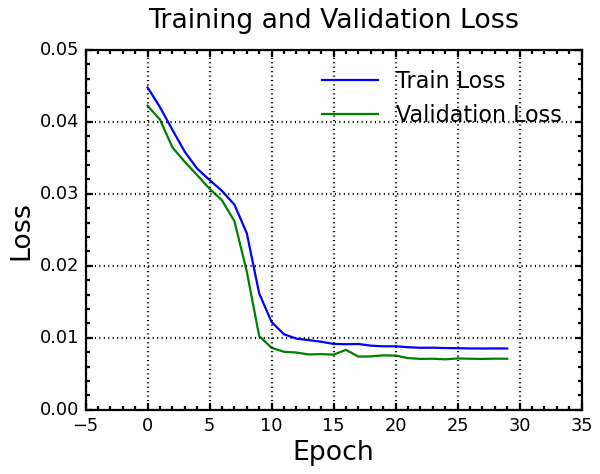

In [80]:
dgcnn_model, y_val_true, y_val_pred = train_dgcnn(
    data_list_train,
    data_list_val,
    activation=nn.PReLU(),
    loss=HuberRelativeLoss(delta=0.05),
    EdgeMLP_dims=[64, 128],
    mlp_dims=[128, 64, 32],
    dropout=0.1,
    lr=1e-3,
    weight_decay=5e-5,
    batch_size=batch_size,
    epochs=30,
    patience=10,
    val_split=0.2,
    random_state=random_state
)
torch.save(dgcnn_model, DataPath_Validate+f"/Models/DGCNN.pth")
# Evaluate on test set

Step 1 Linear fit coeffs: [-0.00155548  0.02803542]


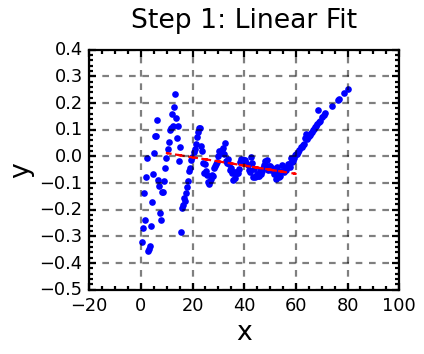

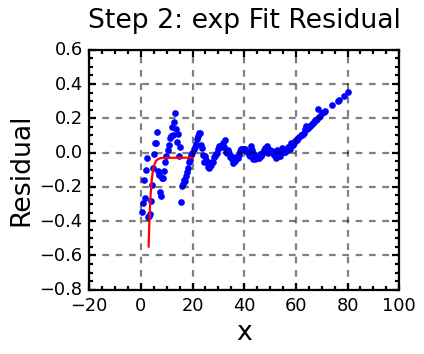

Step 3 Linear fit coeffs: [-0.00320033  0.04421915]


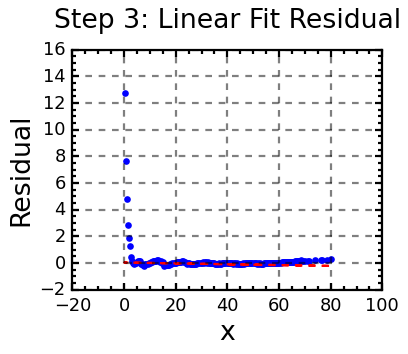

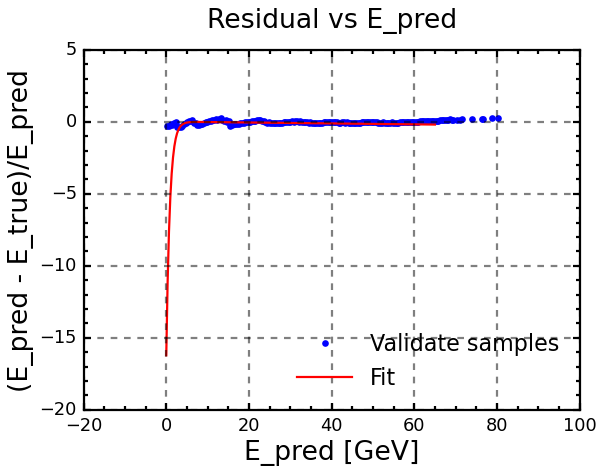

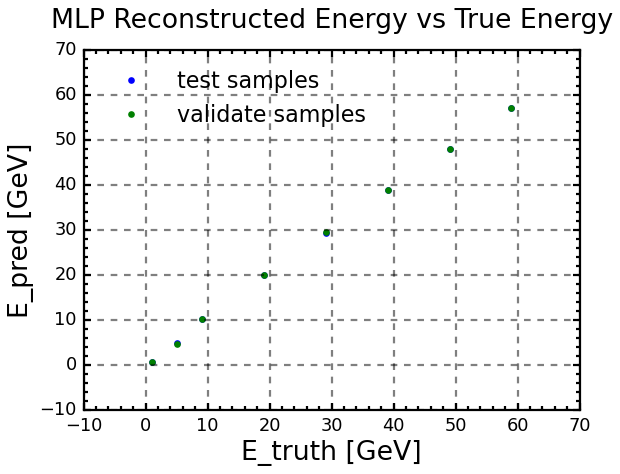

In [81]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (3, 20)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

Reco_hist_all = []

device = next(dgcnn_model.parameters()).device
dgcnn_model.eval()
test_loader = PyGDataLoader(data_list_test, batch_size=batch_size, shuffle=False)
y_test_true, y_test_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = dgcnn_model(batch)
        y_test_true.append(batch.y.cpu())
        y_test_pred.append(pred.cpu())
y_test_true = torch.cat(y_test_true, dim=0).numpy()
y_test_pred = torch.cat(y_test_pred, dim=0).numpy()

#Reco_hist_all.clear()
#Reco_hist = build_reco_hist(y_test_pred, E_truth_test, Energy_test, Nbins=50)
#Reco_hist_all.append(Reco_hist)

fit_range = (0, 65) 
mask = y_val_pred>0
residual_E = (y_val_pred[mask] - y_val_true[mask]) / y_val_pred[mask]
E_calib_fit = Combined_fit(y_val_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=200)
x_fit = np.linspace(fit_range[0], fit_range[1], 200)
y_fit = E_calib_fit(x_fit)
plt.figure(figsize=fig_size)
plot_binned(y_val_pred[mask], residual_E, num_bins=200, color="blue", label="Validate samples")
#plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
plt.plot(x_fit, y_fit, color='red', label='Fit')
plt.xlabel("E_pred [GeV]")
plt.ylabel("(E_pred - E_true)/E_pred")
plt.title("Residual vs E_pred")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

y_val_pred_calib = y_val_pred*(1-E_calib_fit(y_val_pred))
y_test_pred_calib = y_test_pred*(1-E_calib_fit(y_test_pred))
Reco_hist_all.clear()
Reco_hist = build_reco_hist(y_test_pred_calib, E_truth_test, Energy_test, Nbins=50)
Reco_hist_all.append(Reco_hist)

plt.figure(figsize=fig_size)
plot_binned(y_test_true, y_test_pred, color="blue", label="test samples")
plot_binned(y_val_true, y_val_pred, color="green", label="validate samples")
plt.xlabel("E_truth [GeV]")
plt.ylabel("E_pred [GeV]")
plt.title("MLP Reconstructed Energy vs True Energy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")  
plt.show()


In [82]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


length of Reco_hist_all: 1
length of Reco_hist: 12
Mean: 10.319768008879203, Peak: 9.906927376153405, RMS: 1.935658544061154
Initial Gamma Fit Parameters: [np.float64(1495.0883705190622), np.float64(2.918278906883719), np.float64(4.670976508816287), np.float64(1.935658544061154)]
Gamma Fit Bounds: lower [np.float64(14.950883705190622), np.float64(-0.708172109311628), np.float64(-0.5329023491183713), np.float64(0.1935658544061154)], 
 upper [np.float64(8970.530223114372), np.float64(29.18278906883719), np.float64(17.00646476322443), np.float64(19.35658544061154)]
Gamma Fit Parameters: [1.48155845e+03 2.14707986e+01 1.65661543e+00 4.02073446e-01]
Gamma Fit Peak: 9.887379959775284 ± 0.042064215027366104, Mean: 10.289453405853273 ± 0.042882520247558155, Resolution: 0.18842922728690373 ± 0.003430818417057628


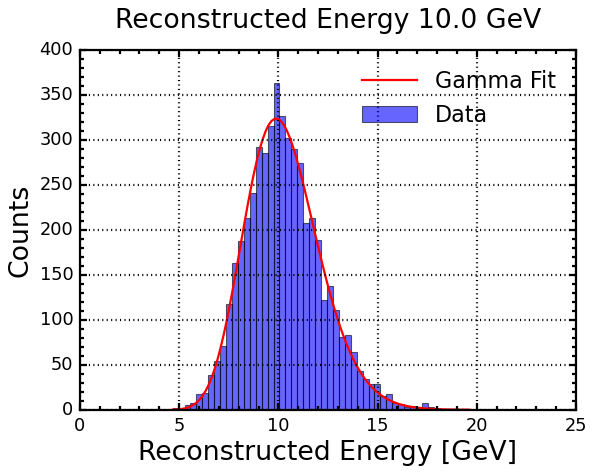

In [83]:
#This cell is left here for debug
print("length of Reco_hist_all:", len(Reco_hist_all))
Reco_hist = Reco_hist_all[0] # Example for first beta
print("length of Reco_hist:", len(Reco_hist))
i_E = 6 # Example index, change as needed
#print(len(Reco_hist))
#print(Reco_hist[i_E])
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
    "E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])

Mean: 1.5659149869968558, Peak: 1.5099359575237863, RMS: 0.3227999141451058
Initial Gamma Fit Parameters: [np.float64(241.84254954649947), np.float64(2.206429316928025), np.float64(0.853679792925245), np.float64(0.3227999141451058)]
Gamma Fit Bounds: lower [np.float64(2.418425495464995), np.float64(-0.7793570683071975), np.float64(-0.9146320207074755), np.float64(0.03227999141451058)], 
 upper [np.float64(1451.055297278997), np.float64(22.06429316928025), np.float64(11.280519689387868), np.float64(3.2279991414510576)]
Gamma Fit Parameters: [2.27990426e+02 7.09210104e+00 8.92683982e-01 9.09172708e-02]
Gamma Fit Peak: 1.4465611825157119 ± 0.008549375716207466, Mean: 1.537478453312478 ± 0.00910179153824375, Resolution: 0.16737748608824415 ± 0.005817800751771498


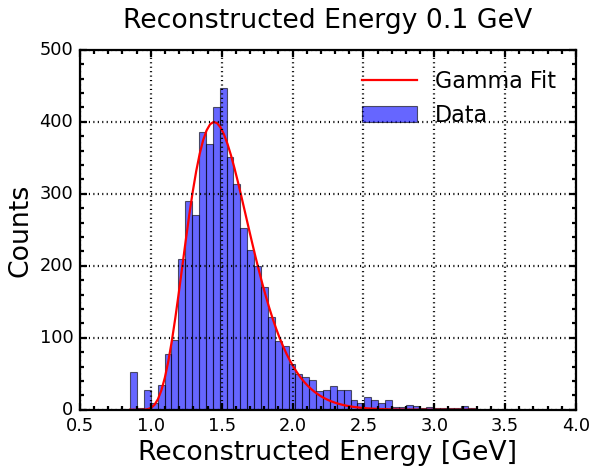

appending results for E = 0.1
Mean_Gamma: 1.537478453312478 Mean_Gamma_Error: 0.00910179153824375
Peak_Gamma: 1.4465611825157119 Peak_Gamma_Error: 0.008549375716207466
Mean: 2.76611685952426, Peak: 2.367430712731754, RMS: 0.791814801150305
Initial Gamma Fit Parameters: [np.float64(515.0590371132275), np.float64(2.2605059046036695), np.float64(0.976214826171415), np.float64(0.791814801150305)]
Gamma Fit Bounds: lower [np.float64(5.150590371132275), np.float64(-0.7739494095396331), np.float64(-0.9023785173828585), np.float64(0.07918148011503051)], 
 upper [np.float64(3090.354222679365), np.float64(22.605059046036693), np.float64(11.464322239257122), np.float64(7.91814801150305)]
Gamma Fit Parameters: [529.79340444   2.8104105    1.27687823   0.56313332]
Gamma Fit Peak: 2.296380716610783 ± 0.03745383836122148, Mean: 2.859514039317819 ± 0.04569600999967563, Resolution: 0.4111044857254679 ± 0.024375775884510224


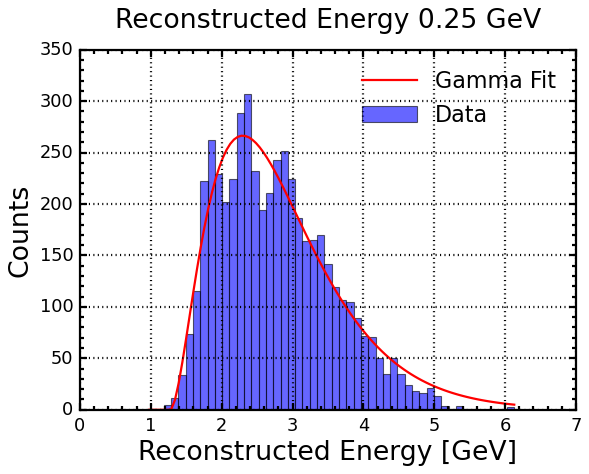

appending results for E = 0.25
Mean_Gamma: 2.859514039317819 Mean_Gamma_Error: 0.04569600999967563
Peak_Gamma: 2.296380716610783 Peak_Gamma_Error: 0.03745383836122148
Mean: 4.448561228771839, Peak: 4.824063679045091, RMS: 0.8604513836825202
Initial Gamma Fit Parameters: [np.float64(527.2725936211692), np.float64(4.15949357483522), np.float64(0.8695192268863214), np.float64(0.8604513836825202)]
Gamma Fit Bounds: lower [np.float64(5.2727259362116925), np.float64(-0.584050642516478), np.float64(-0.9130480773113678), np.float64(0.08604513836825202)], 
 upper [np.float64(3163.6355617270156), np.float64(41.5949357483522), np.float64(11.304278840329482), np.float64(8.604513836825202)]
Gamma Fit Parameters: [ 5.55142317e+02  3.38458474e+01 -9.13048077e-01  1.64801832e-01]
Gamma Fit Peak: 4.500007748647969 ± 0.04255679228220855, Mean: 4.664809580427212 ± 0.05785155474052215, Resolution: 0.2130597775833769 ± 0.009930930679934374


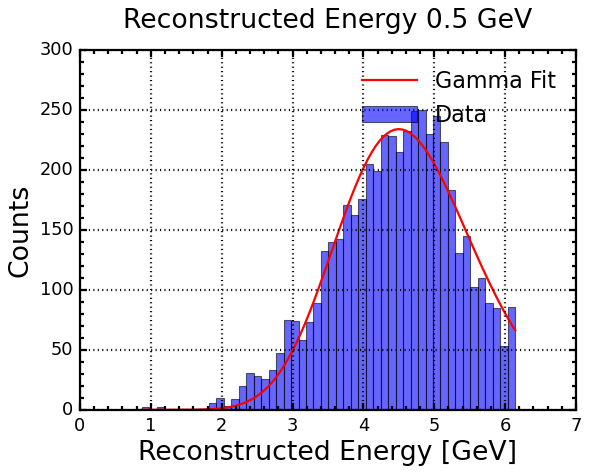

appending results for E = 0.5
Mean_Gamma: 4.664809580427212 Mean_Gamma_Error: 0.05785155474052215
Peak_Gamma: 4.500007748647969 Peak_Gamma_Error: 0.04255679228220855
Mean: 5.799628482781164, Peak: 6.119025764693875, RMS: 0.393026723862632
Initial Gamma Fit Parameters: [np.float64(231.9679589168669), np.float64(5.037429979739726), np.float64(3.8197838811566545), np.float64(0.393026723862632)]
Gamma Fit Bounds: lower [np.float64(2.3196795891686692), np.float64(-0.4962570020260274), np.float64(-0.6180216118843345), np.float64(0.0393026723862632)], 
 upper [np.float64(1391.8077535012014), np.float64(50.37429979739726), np.float64(15.729675821734983), np.float64(3.9302672386263198)]
Gamma Fit Parameters: [1.39180775e+03 3.72473175e+01 4.97399414e+00 3.93026724e-02]
Gamma Fit Peak: 6.398610578895951 ± 2.202539829360526, Mean: 6.437913251282215 ± 3.0081193583905983, Resolution: 0.03748727755851259 ± 0.21661849298430144


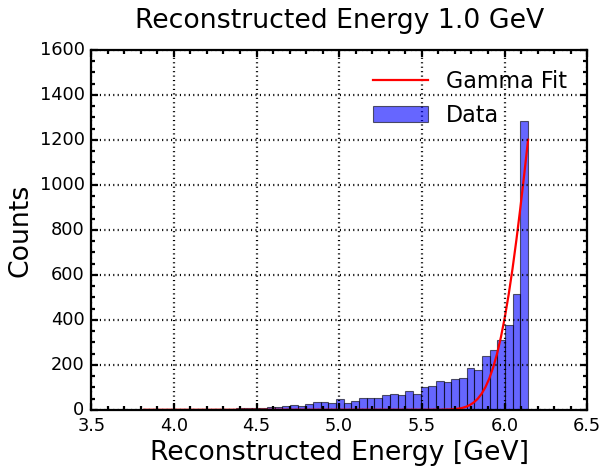

appending results for E = 1.0
Mean_Gamma: 6.437913251282215 Mean_Gamma_Error: 3.0081193583905983
Peak_Gamma: 6.398610578895951 Peak_Gamma_Error: 2.202539829360526
Mean: 5.5763249698162305, Peak: 6.109353681584364, RMS: 0.41552140778668917
Initial Gamma Fit Parameters: [np.float64(203.86268809479998), np.float64(2.5938704275250957), np.float64(4.498516278154741), np.float64(0.41552140778668917)]
Gamma Fit Bounds: lower [np.float64(2.0386268809479997), np.float64(-0.7406129572474904), np.float64(-0.5501483721845258), np.float64(0.04155214077866892)], 
 upper [np.float64(1223.1761285687999), np.float64(25.938704275250956), np.float64(16.74777441723211), np.float64(4.155214077866892)]
Gamma Fit Parameters: [2.09075782e+02 2.59387043e+01 3.40210446e+00 8.93661689e-02]
Gamma Fit Peak: 5.6307809200867425 ± 0.06083697571129021, Mean: 5.720147089014844 ± 0.0734873063079759, Resolution: 0.08083112977499399 ± 0.009602106398703026


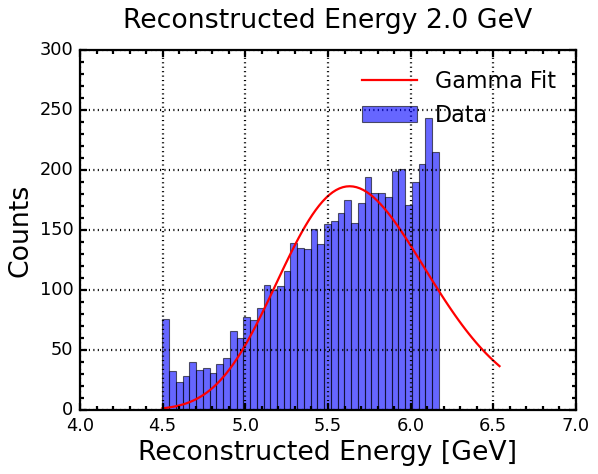

appending results for E = 2.0
Mean_Gamma: 5.720147089014844 Mean_Gamma_Error: 0.0734873063079759
Peak_Gamma: 5.6307809200867425 Peak_Gamma_Error: 0.06083697571129021
Mean: 5.23638713444617, Peak: 4.546208383120749, RMS: 0.7675039910575906
Initial Gamma Fit Parameters: [np.float64(476.5385029772924), np.float64(0.9615272388777026), np.float64(4.498411141096948), np.float64(0.7675039910575906)]
Gamma Fit Bounds: lower [np.float64(4.765385029772924), np.float64(-0.9038472761122297), np.float64(-0.5501588858903051), np.float64(0.07675039910575907)], 
 upper [np.float64(2859.2310178637545), np.float64(9.615272388777026), np.float64(16.74761671164542), np.float64(7.675039910575906)]
Gamma Fit Parameters: [427.98266716   0.95984865   4.54620832   0.88509338]
Gamma Fit Peak: 4.510670626826228 ± 0.021258270595578898, Mean: 5.395764002892377 ± 0.01892328269044163, Resolution: 0.1922424774737271 ± 0.006627258979604348


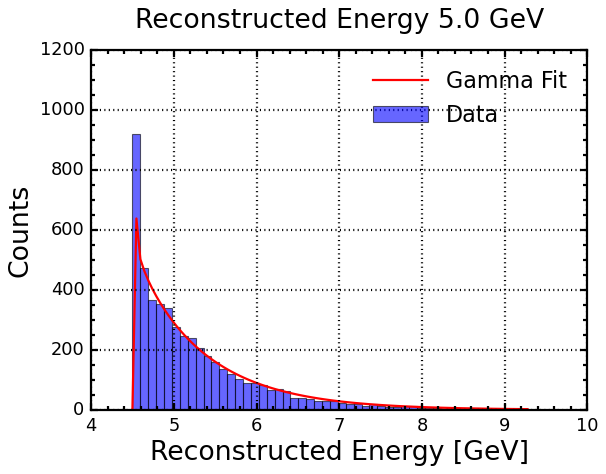

appending results for E = 5.0
Mean_Gamma: 5.395764002892377 Mean_Gamma_Error: 0.01892328269044163
Peak_Gamma: 4.510670626826228 Peak_Gamma_Error: 0.021258270595578898
Mean: 10.319768008879203, Peak: 9.906927376153405, RMS: 1.935658544061154
Initial Gamma Fit Parameters: [np.float64(1495.0883705190622), np.float64(2.918278906883719), np.float64(4.670976508816287), np.float64(1.935658544061154)]
Gamma Fit Bounds: lower [np.float64(14.950883705190622), np.float64(-0.708172109311628), np.float64(-0.5329023491183713), np.float64(0.1935658544061154)], 
 upper [np.float64(8970.530223114372), np.float64(29.18278906883719), np.float64(17.00646476322443), np.float64(19.35658544061154)]
Gamma Fit Parameters: [1.48155845e+03 2.14707986e+01 1.65661543e+00 4.02073446e-01]
Gamma Fit Peak: 9.887379959775284 ± 0.042064215027366104, Mean: 10.289453405853273 ± 0.042882520247558155, Resolution: 0.18842922728690373 ± 0.003430818417057628


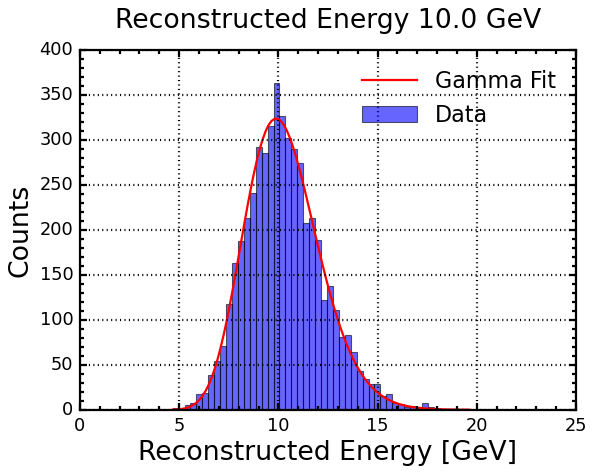

appending results for E = 10.0
Mean_Gamma: 10.289453405853273 Mean_Gamma_Error: 0.042882520247558155
Peak_Gamma: 9.887379959775284 Peak_Gamma_Error: 0.042064215027366104
Mean: 20.962503368802082, Peak: 20.344073173096767, RMS: 2.974399195425777
Initial Gamma Fit Parameters: [np.float64(2587.5740406080185), np.float64(3.774706427928217), np.float64(9.735019606603885), np.float64(2.974399195425777)]
Gamma Fit Bounds: lower [np.float64(25.875740406080187), np.float64(-0.6225293572071783), np.float64(-0.02649803933961148), np.float64(0.2974399195425777)], 
 upper [np.float64(15525.444243648111), np.float64(37.74706427928217), np.float64(24.602529409905827), np.float64(29.74399195425777)]
Gamma Fit Parameters: [2.54315572e+03 1.85408081e+01 8.96575649e+00 6.47201313e-01]
Gamma Fit Peak: 20.31819055297962 ± 0.047219187060309926, Mean: 20.965391866090343 ± 0.04828992078610978, Resolution: 0.1371572252739098 ± 0.0018556144446740086


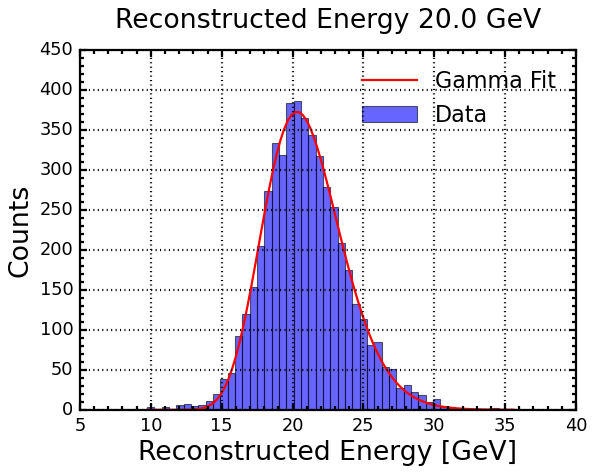

appending results for E = 20.0
Mean_Gamma: 20.965391866090343 Mean_Gamma_Error: 0.04828992078610978
Peak_Gamma: 20.31819055297962 Peak_Gamma_Error: 0.047219187060309926
Mean: 31.684180906770507, Peak: 31.055091646548096, RMS: 3.731498914705933
Initial Gamma Fit Parameters: [np.float64(3402.176279868545), np.float64(4.637928178742141), np.float64(14.377756941310144), np.float64(3.731498914705933)]
Gamma Fit Bounds: lower [np.float64(34.02176279868545), np.float64(-0.5362071821257859), np.float64(0.43777569413101447), np.float64(0.3731498914705933)], 
 upper [np.float64(20413.05767921127), np.float64(46.379281787421405), np.float64(31.566635411965215), np.float64(37.31498914705933)]
Gamma Fit Parameters: [3.36928563e+03 1.04239940e+01 2.01390869e+01 1.11418574e+00]
Gamma Fit Peak: 30.639166749799664 ± 0.06596349807782259, Mean: 31.75335249474258 ± 0.0687381047493242, Resolution: 0.11740800935829798 ± 0.0018838493213484157


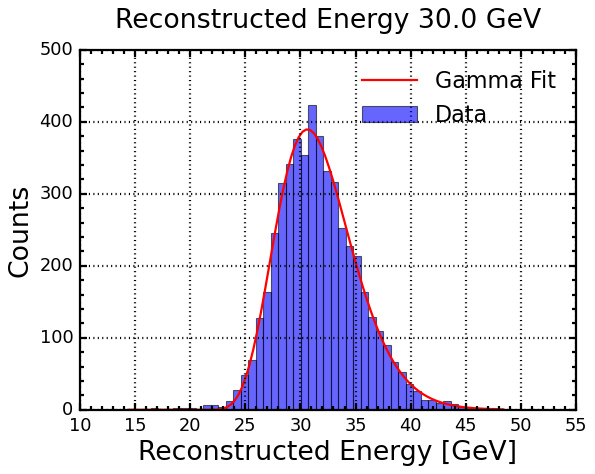

appending results for E = 30.0
Mean_Gamma: 31.75335249474258 Mean_Gamma_Error: 0.0687381047493242
Peak_Gamma: 30.639166749799664 Peak_Gamma_Error: 0.06596349807782259
Mean: 43.08273527923666, Peak: 42.21190843661361, RMS: 4.452653191900353
Initial Gamma Fit Parameters: [np.float64(4266.918989417924), np.float64(4.5121822394250195), np.float64(22.991552628424763), np.float64(4.452653191900353)]
Gamma Fit Bounds: lower [np.float64(42.66918989417925), np.float64(-0.548781776057498), np.float64(1.2991552628424765), np.float64(0.4452653191900353)], 
 upper [np.float64(25601.513936507545), np.float64(45.121822394250195), np.float64(44.48732894263715), np.float64(44.52653191900353)]
Gamma Fit Parameters: [4.22047610e+03 1.32991771e+01 2.76283917e+01 1.15772941e+00]
Gamma Fit Peak: 41.8675106475064 ± 0.08306827580365013, Mean: 43.02524005505336 ± 0.08574833613249123, Resolution: 0.10084219949567771 ± 0.0016396901376083365


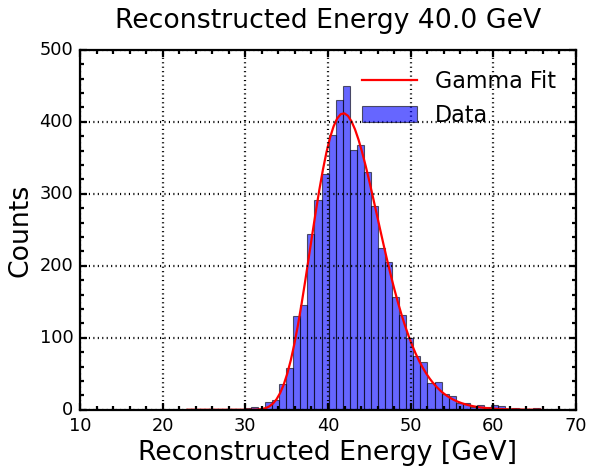

appending results for E = 40.0
Mean_Gamma: 43.02524005505336 Mean_Gamma_Error: 0.08574833613249123
Peak_Gamma: 41.8675106475064 Peak_Gamma_Error: 0.08306827580365013
Mean: 54.75561084434227, Peak: 52.604413933214765, RMS: 5.052054595011252
Initial Gamma Fit Parameters: [np.float64(4741.798455036128), np.float64(4.4657752577657455), np.float64(32.19427043305928), np.float64(5.052054595011252)]
Gamma Fit Bounds: lower [np.float64(47.41798455036128), np.float64(-0.5534224742234255), np.float64(2.219427043305928), np.float64(0.5052054595011252)], 
 upper [np.float64(28450.790730216766), np.float64(44.657752577657455), np.float64(58.291405649588924), np.float64(50.52054595011252)]
Gamma Fit Parameters: [4.68307834e+03 1.57145979e+01 3.57326269e+01 1.20920674e+00]
Gamma Fit Peak: 53.52561789901753 ± 0.09501702621843514, Mean: 54.73482464120113 ± 0.09758278685441708, Resolution: 0.08955513787395226 ± 0.0014165039791337157


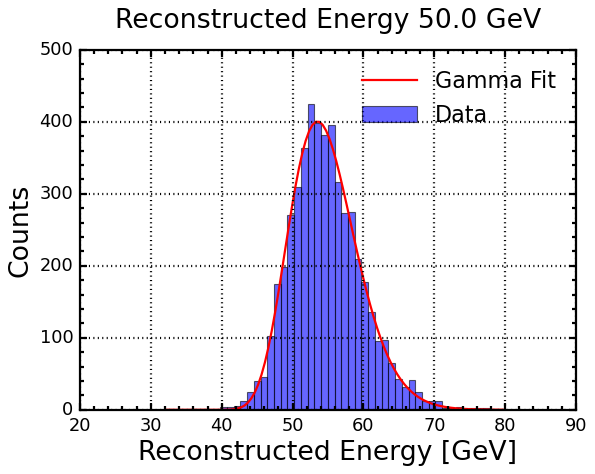

appending results for E = 50.0
Mean_Gamma: 54.73482464120113 Mean_Gamma_Error: 0.09758278685441708
Peak_Gamma: 53.52561789901753 Peak_Gamma_Error: 0.09501702621843514
Mean: 66.62550381920428, Peak: 65.59519330994192, RMS: 5.850039439432883
Initial Gamma Fit Parameters: [np.float64(5326.621003700548), np.float64(4.095307129281651), np.float64(42.66779559631596), np.float64(5.850039439432883)]
Gamma Fit Bounds: lower [np.float64(53.26621003700548), np.float64(-0.5904692870718349), np.float64(3.2667795596315967), np.float64(0.5850039439432883)], 
 upper [np.float64(31959.726022203286), np.float64(40.95307129281651), np.float64(74.00169339447395), np.float64(58.50039439432883)]
Gamma Fit Parameters: [5.25277349e+03 1.74573633e+01 4.38807658e+01 1.29408511e+00]
Gamma Fit Peak: 65.17799474039079 ± 0.11142309777817366, Mean: 66.47207985526163 ± 0.11411476675634835, Resolution: 0.08295664358885632 ± 0.0013368523405956616


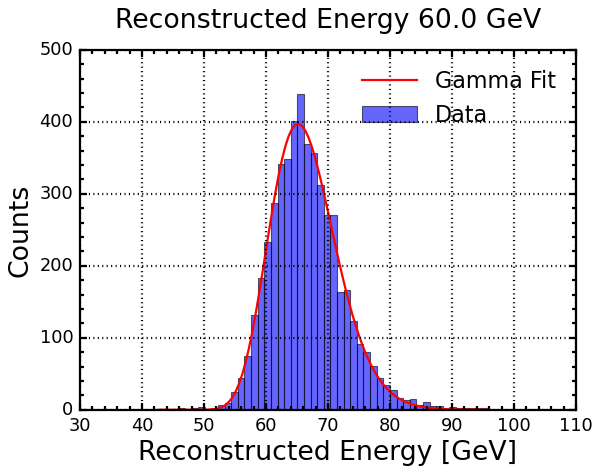

appending results for E = 60.0
Mean_Gamma: 66.47207985526163 Mean_Gamma_Error: 0.11411476675634835
Peak_Gamma: 65.17799474039079 Peak_Gamma_Error: 0.11142309777817366


In [84]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_DGCNN_Fit.csv")
OutputCSV(Reco_hist_all[0], Energy_test, outputfile_name)
# for i_para, para in enumerate(ParameterScan):
#     if i_para != 0:
#         continue  # 
#     #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
#     outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
#     OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")